# 实验名称：哈勃深空图像的宇宙射线剔除

* 姓名：周星辉
* 班级：22天文
* 学号：2112219036

## 一、实验目的： 
    1、学会使用python以及其与天文图像处理相关的包，并尝试性的对天文图像进行处理。
    2、熟悉fits文件的数据组成和读出以及后续处理方法，并运用python对fits文件进行数据处理。
    3、学会观察图像的直方图，明确直方图的作用和意义。
    4、了解天文图像处理的常用方法和技术手段，并在此次实验采用一部分。
    5、观察包含宇宙射线的深空天文图像，对天文图像处理形成初步的理解。

## 二、实验条件：
    1、在MacBook上运行的python语言和与天文图像处理相关的python包
    2、一幅来自哈勃望远镜的深空图像

## 三、实验步骤：
    1、载入图像的fits格式的文件。
    2、画一个图像的直方图，观察一下图像的能量分布，给出一个图像的最佳的显示效果。
    3、根据对直方图的观察研究一下如何获得最优的阈值。
    4、根据阈值，将图像转变为二值图。
    5、在二值图的基础上，对图像进行相关的形态学处理，去除宇宙射线。
    6、将去除宇宙射线后的二值图乘于原图，最后得到经过处理后的图像。

## 四、实验过程及原理：

In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import exposure
import numpy as np
from scipy.stats import norm
from matplotlib.colors import LogNorm
plt.rcParams['font.sans-serif']='Heiti TC'
%matplotlib inline

# 从fits文件中读取数据

In [6]:
raw_data = fits.getdata('jbit11e1q_flc.fits').astype('float')
raw_data = np.flip(raw_data, axis=0)
 #plt.imshow(raw_data)

# 统计原图矩阵，画出直方分布，寻找规律

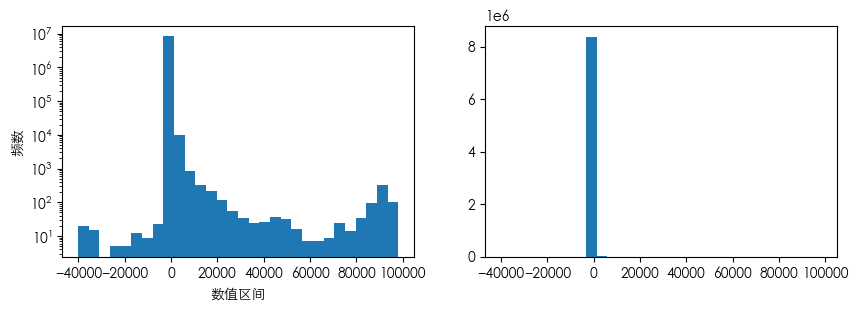

In [16]:
# 直方分布
plt.figure(figsize=(10,3))
plt.subplot(121)
y, bins,_ = plt.hist(raw_data.ravel(), bins=30, log=True)
# 区间中点（横坐标）
x = (bins[1:] + bins[:-1])/2
plt.xlabel('数值区间')
plt.ylabel('频数')
plt.subplot(122)
plt.hist(raw_data.ravel(),bins=30)
plt.show()

# 直方图均衡化
原图比较的灰暗，基本上看不到什么细节，可以推测是对比度太低，于是对图片进行直方均衡。以能量集中的97.9的区域进行线性的对比度拉升。

0.2908694588620336 0.2913793883275657


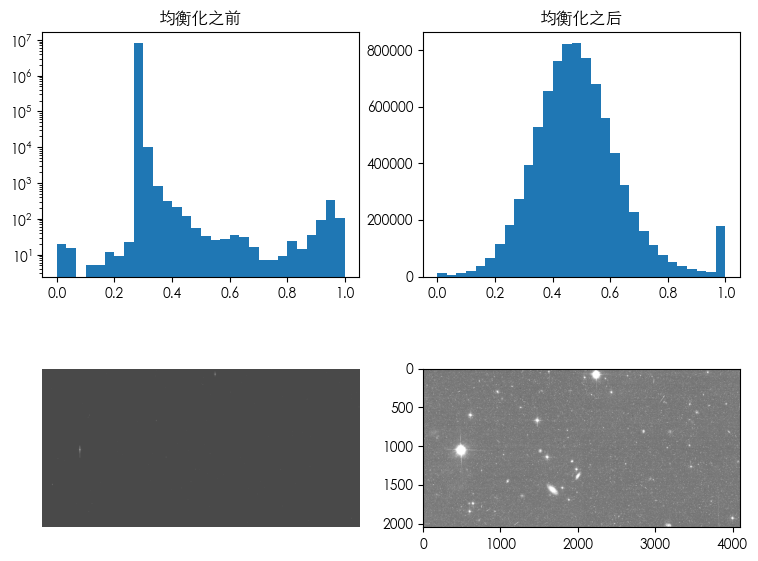

In [21]:
# 先进行归一化
img = (raw_data - np.min(raw_data))/(np.max(raw_data)-np.min(raw_data))
# 均衡化，进行对比度拉伸
p1, p2 = np.percentile(img, (0.1, 98))
print(p1, p2)
img_rescale = exposure.rescale_intensity(img, (p1, p2))

plt.figure(figsize=(9,7))
plt.subplot(221)
plt.title('均衡化之前')
plt.hist(img.ravel(), bins=30,log=True)
plt.subplot(223)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(222)
plt.title('均衡化之后')
plt.hist(img_rescale.ravel(), bins=30)
plt.subplot(224)
plt.imshow(img_rescale, cmap='gray')

plt.show()

# 拟合正态分布，3sigma原则
通过观察可以发现，全图的像素分布包含了一个比较大的正态分布，因此可以假设：
* 宇宙背景的辐射强度是符合正态分布的，占了全图的大部分能量。
* 对于背景来说，亮度较大的星星和宇宙射线等可以视为是异常点，占据少部分的能量。
* 因此，通过3sigma取该正态分布的右侧3sigma外的数据作为亮点检测。
* 从而找到一个较为合理的阈值来对图像进行二值化，区分开图像的前景和背景。


In [19]:
img_1w=raw_data.flatten()
delta=1000000


while True:
    n,bins,_=plt.hist(img_1w, bins=1000, color='black')
    
    mu=np.mean(img_1w)
    std=np.std(img_1w)
    
    x=(bins[1:]+bins[:-1])/2
    y=norm.pdf(x,mu,std)
    y=y/sum(y)*img_1w.size
    #plt.plot(x,y,color='r')
    plt.close()
    error=sum(abs(y-n))/y.size # 计算绝对值误差
    
    if error<delta:   #如果前后两次迭代没有什么优化就退出循环, 否则继续，把3sigma外的数据剔除掉，从而找到一个更准确的正态分布的位置
        img_1w=img_1w[img_1w<=mu+3*std]
        img_1w=img_1w[img_1w>=mu-3*std]
        delta=error
    else:
        break

threshold = mu + 3*std
print('threshold: '+str(threshold))

threshold: 81.01174434428869


# 二值化处理
在找到的最佳阈值的基础上，对原图做二值化处理

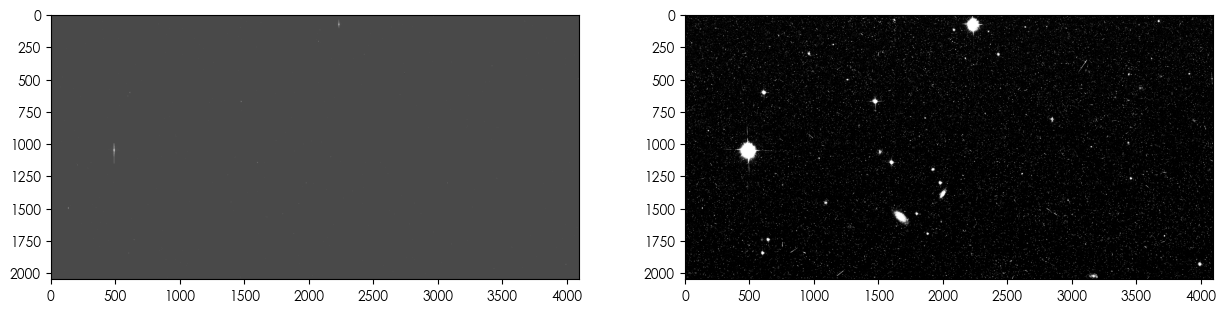

In [17]:
img_split = raw_data.copy()
img_split[raw_data>=threshold]=1
img_split[raw_data<threshold]=0

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.imshow(raw_data, 'gray')
plt.subplot(122)
plt.imshow(img_split, 'gray')

# 进行开闭运算操作
* 闭运算：先膨胀在腐蚀； 开运算：先腐蚀再膨胀。
* 对二值化后的图先进行闭运算操作，把一些把一些像素空洞进行填补，然后在进行开运算把小的亮点进行剔除

(-0.5, 999.5, 999.5, -0.5)

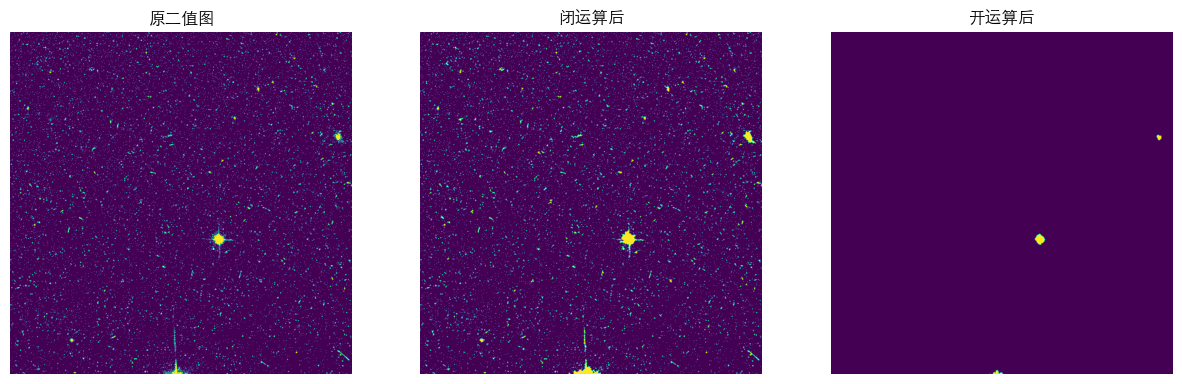

In [20]:
# 进行开运算（先腐蚀，后膨胀）, 对二值图进行操作
closed = morphology.closing(img_split, morphology.disk(2))
opened = morphology.opening(img_split, footprint=morphology.disk(4))
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img_split[:1000,:1000])
plt.title('原二值图')
plt.axis('off')
plt.subplot(132)
plt.imshow(closed[:1000, :1000])
plt.title('闭运算后')
plt.axis('off')
plt.subplot(133)
plt.imshow(opened[:1000, :1000])
plt.title('开运算后')
plt.axis('off')


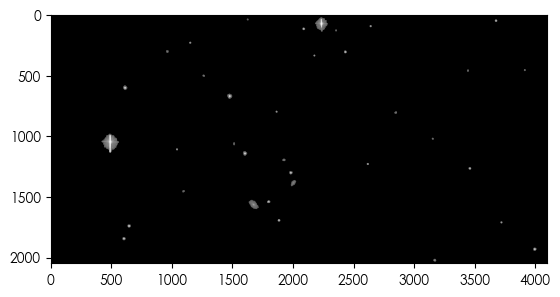

In [12]:
result_img = opened*raw_data + 1
plt.imshow(result_img, 'gray', norm=LogNorm(), )

# 把处理后的写入到新的fits文件当中

In [13]:
myhdu = fits.PrimaryHDU(result_img)
myhdu.writeto('myfits.fits', overwrite=True)